**Segmentation Model - U-Net++** - train_unetpp_wbc_segmentation

U-Net++ WBC Segmentation Trainer - train_unetpp_wbc_segmentation

U-Net++ Visualization & Evaluation - evaluate_unetpp_results

U-Net++ WBC Counting (Connected Components) - count_wbc_from_unetpp_masks

In [ ]:
# Option 1 (segmentation-only for WBC): Use U-Net++ counts directly for the “WBC count” in your rule engine.
# Option 2 (hybrid):
# 1. Run YOLO(WBC) → get boxes,
# 2. For each box, crop and run U-Net++ → refine mask & count (good for clumped cells).
# Keep bacteria/yeast as YOLO detectors (unless you also have masks for them).

In [ ]:
import os; os.kill(os.getpid(), 9)

In [ ]:
# ❌ Do NOT import numpy/cv2/torch/etc in this cell
# Clean out conflicting wheels that force NumPy 2.x or wrong OpenCV builds
!pip -q uninstall -y numpy jax jaxlib pytensor thinc \
    opencv-python opencv-contrib-python opencv-python-headless \
    albucore albumentations segmentation-models-pytorch ultralytics

# Install a mutually compatible stack for computer vision
!pip -q install \
  "numpy==1.26.4" \
  "opencv-python-headless==4.7.0.72" \
  "albumentations==1.3.1" \
  "segmentation-models-pytorch==0.3.3" \
  "ultralytics==8.3.0" \
  "torchmetrics>=1.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 104.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.3/881.3 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 11.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does 

In [ ]:
# ✅ Now imports are safe — the runtime is fresh
import numpy as np, cv2, albumentations as A, segmentation_models_pytorch as smp
from ultralytics import YOLO
import torch

print("NumPy:", np.__version__)              # expect 1.26.4
print("OpenCV:", cv2.__version__)            # expect 4.7.0
print("Albumentations:", A.__version__)      # expect 1.3.1
print("SMP:", smp.__version__)               # expect 0.3.3
print("Ultralytics 8.3.0 OK")
print("Torch:", torch.__version__)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
NumPy: 2.0.2
OpenCV: 4.12.0
Albumentations: 2.0.8
SMP: 0.3.3
Ultralytics 8.3.0 OK
Torch: 2.8.0+cu126


In [ ]:
# 1) Mount Drive and define your project layout
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
ROOT = Path("/content/drive/MyDrive/urine_uti/ml-services/kasundi")

# Dataset (images + masks). If you only have YOLO labels, see Step 2 to auto-make masks.
DATA_ROOT = ROOT / "data" / "processed" / "wbc_detect"
IMG_TRAIN = DATA_ROOT / "images" / "train"
IMG_VAL   = DATA_ROOT / "images" / "val"
IMG_TEST  = DATA_ROOT / "images" / "test"

MSK_TRAIN = DATA_ROOT / "masks" / "train"  # <-- if missing, Step 2 can create these
MSK_VAL   = DATA_ROOT / "masks" / "val"
MSK_TEST  = DATA_ROOT / "masks" / "test"

# Results / outputs
RESULTS_DIR = ROOT / "results" / "wbc_unetpp"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Images:", IMG_TRAIN.exists(), IMG_VAL.exists(), IMG_TEST.exists())
print("Masks: ", MSK_TRAIN.exists(), MSK_VAL.exists(), MSK_TEST.exists())

Mounted at /content/drive
Images: True True True
Masks:  True True True


In [ ]:
#Option B — You only have YOLO boxes (quick baseline):
#Make “pseudo-masks” by filling each bounding box as a 1-valued rectangle. It’s not perfect, but good enough to start.

In [ ]:
# 2) ONLY RUN if you don't have masks. It will create binary masks by filling YOLO boxes.
import os, glob, cv2, numpy as np
from pathlib import Path
from PIL import Image

LBL_TRAIN = DATA_ROOT / "labels" / "train"
LBL_VAL   = DATA_ROOT / "labels" / "val"
LBL_TEST  = DATA_ROOT / "labels" / "test"

def yolo_to_xyxy(cx, cy, w, h, W, H):
    bw, bh = w*W, h*H
    x,  y  = cx*W, cy*H
    x1, y1 = int(max(0, x - bw/2)), int(max(0, y - bh/2))
    x2, y2 = int(min(W-1, x + bw/2)), int(min(H-1, y + bh/2))
    return x1, y1, x2, y2

def build_masks(images_dir: Path, labels_dir: Path, out_dir: Path):
    out_dir.mkdir(parents=True, exist_ok=True)
    for ip in images_dir.glob("*.*"):
        name = ip.stem
        lab  = labels_dir / f"{name}.txt"
        img  = cv2.imread(str(ip), cv2.IMREAD_COLOR)
        if img is None: continue
        H, W = img.shape[:2]
        msk  = np.zeros((H, W), np.uint8)
        if lab.exists():
            with open(lab) as f:
                for line in f.read().strip().splitlines():
                    parts = line.split()
                    if len(parts) != 5: continue
                    _, cx, cy, w, h = map(float, parts)
                    x1, y1, x2, y2 = yolo_to_xyxy(cx, cy, w, h, W, H)
                    cv2.rectangle(msk, (x1,y1), (x2,y2), color=1, thickness=-1)
        cv2.imwrite(str(out_dir / f"{name}.png"), msk)

# Uncomment if masks missing:
build_masks(IMG_TRAIN, LBL_TRAIN, MSK_TRAIN)
build_masks(IMG_VAL,   LBL_VAL,   MSK_VAL)
build_masks(IMG_TEST,  LBL_TEST,  MSK_TEST)

print("After generation, masks exist?",
      MSK_TRAIN.exists(), MSK_VAL.exists(), MSK_TEST.exists())


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

Saving to: /content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp/unetpp_wbc_20251029_0103
[001/60] tl=0.4430 vd=0.7420 vi=0.6285
  -> saved BEST: /content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp/unetpp_wbc_20251029_0103/unetpp_best.pth
[002/60] tl=0.1693 vd=0.7581 vi=0.6459
  -> saved BEST: /content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp/unetpp_wbc_20251029_0103/unetpp_best.pth
[003/60] tl=0.1417 vd=0.7313 vi=0.6284
[004/60] tl=0.1347 vd=0.7774 vi=0.6721
  -> saved BEST: /content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp/unetpp_wbc_20251029_0103/unetpp_best.pth
[005/60] tl=0.1285 vd=0.7729 vi=0.6674
[006/60] tl=0.1281 vd=0.7688 vi=0.6666
[007/60] tl=0.1212 vd=0.7754 vi=0.6688
[008/60] tl=0.1173 vd=0.7853 vi=0.6848
  -> saved BEST: /content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp/unetpp_wbc_20251029_0103/unetpp_best.pth
[009/60] tl=0.1137 vd=0.7773 vi=0.6730
[010/60] tl=0.1164 vd

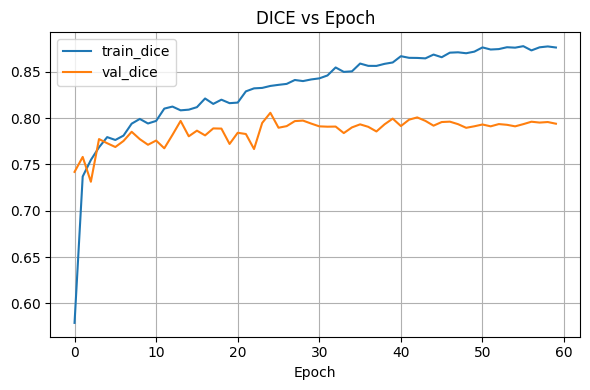

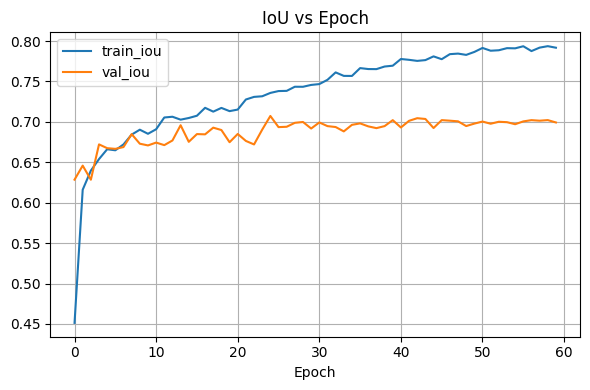

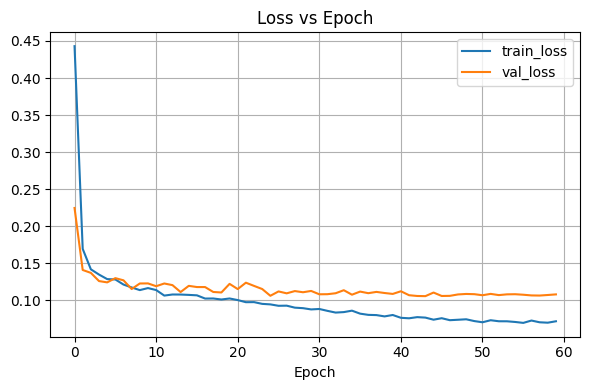

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import torch, cv2, numpy as np, glob, datetime, pandas as pd, matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMGSZ, BATCH, EPOCHS = 512, 4, 60

class SegDataset(Dataset):
    def __init__(self, img_dir, msk_dir, split="train", img_size=512):
        self.imgs = sorted([p for p in img_dir.iterdir() if p.suffix.lower() in (".jpg",".jpeg",".png",".tif",".tiff")])
        self.msk_dir = msk_dir; self.split=split
        self.tf = A.Compose([
            A.HorizontalFlip(p=0.5) if split=="train" else A.NoOp(),
            A.Rotate(limit=10, border_mode=cv2.BORDER_REFLECT_101, p=0.5) if split=="train" else A.NoOp(),
            A.RandomBrightnessContrast(0.1,0.1,p=0.5) if split=="train" else A.NoOp(),
            A.Resize(img_size, img_size),
            ToTensorV2(),
        ])
    def __len__(self): return len(self.imgs)
    def __getitem__(self, idx):
        ip = self.imgs[idx]; mp = self.msk_dir / (ip.stem + ".png")
        img = cv2.imread(str(ip))[:,:,::-1]
        msk = cv2.imread(str(mp), cv2.IMREAD_GRAYSCALE);
        if msk is None: msk = np.zeros(img.shape[:2], np.uint8)
        aug = self.tf(image=img, mask=msk)
        x = aug["image"].float()/255.0; y = aug["mask"].unsqueeze(0).float()
        return x, y

train_dl = DataLoader(SegDataset(IMG_TRAIN, MSK_TRAIN, "train", IMGSZ), batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_dl   = DataLoader(SegDataset(IMG_VAL,   MSK_VAL,   "val",   IMGSZ), batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

model = smp.UnetPlusPlus(encoder_name="timm-efficientnet-b0", encoder_weights="imagenet", in_channels=3, classes=1, activation=None).to(DEVICE)
bce  = smp.losses.SoftBCEWithLogitsLoss()
dice = smp.losses.DiceLoss(mode="binary", from_logits=True)
def loss_fn(logits, targets): return 0.5*bce(logits, targets)+0.5*dice(logits, targets)

def dice_score(logits, targets, eps=1e-7):
    p=(torch.sigmoid(logits)>0.5).float(); inter=(p*targets).sum((1,2,3)); union=p.sum((1,2,3))+targets.sum((1,2,3))
    return ((2*inter+eps)/(union+eps)).mean().item()
def iou_score(logits, targets, eps=1e-7):
    p=(torch.sigmoid(logits)>0.5).float(); inter=(p*targets).sum((1,2,3)); union=p.sum((1,2,3))+targets.sum((1,2,3))-inter
    return ((inter+eps)/(union+eps)).mean().item()

# ---- OPT & SCHED ----
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)

# ---- RUN DIRS ----
RUN_NAME = f"unetpp_wbc_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}"
RUN_DIR  = (RESULTS_DIR / RUN_NAME); RUN_DIR.mkdir(parents=True, exist_ok=True)

BEST = RUN_DIR / "unetpp_best.pth"   # weights (best val_dice)
LAST = RUN_DIR / "unetpp_last.pth"   # weights (final)
CKPT = RUN_DIR / "ckpt_last.pth"     # full state (epoch+model+optim+sched)
LOG  = RUN_DIR / "training_log.csv"  # append per-epoch

print("Saving to:", RUN_DIR)

best_dice = 0.0

for e in range(1, EPOCHS+1):
    # ----- Train -----
    model.train(); tl=td=ti=0.0
    for x,y in train_dl:
        x,y = x.to(DEVICE), y.to(DEVICE)
        opt.zero_grad()
        z = model(x)
        L = loss_fn(z,y)
        L.backward(); opt.step()
        tl += L.item()
        with torch.no_grad():
            td += dice_score(z,y)
            ti += iou_score(z,y)

    # ----- Validate -----
    model.eval(); vl=vd=vi=0.0
    with torch.no_grad():
        for x,y in val_dl:
            x,y = x.to(DEVICE), y.to(DEVICE)
            z = model(x)
            vl += loss_fn(z,y).item()
            vd += dice_score(z,y)
            vi += iou_score(z,y)

    sch.step()

    ntr, nva = max(1,len(train_dl)), max(1,len(val_dl))
    log = {
        "epoch": e,
        "train_loss": tl/ntr, "train_dice": td/ntr, "train_iou": ti/ntr,
        "val_loss":   vl/nva, "val_dice":   vd/nva, "val_iou":   vi/nva,
        "lr": sch.get_last_lr()[0]
    }
    print(f"[{e:03d}/{EPOCHS}] tl={log['train_loss']:.4f} vd={log['val_dice']:.4f} vi={log['val_iou']:.4f}")

    # ----- CSV append NOW (so interruptions don’t lose logs) -----
    row = pd.DataFrame([log])
    if LOG.exists(): row.to_csv(LOG, mode="a", header=False, index=False)
    else:            row.to_csv(LOG, index=False)

    # ----- Save best weights -----
    if log["val_dice"] > best_dice:
        best_dice = log["val_dice"]
        torch.save(model.state_dict(), BEST)
        print("  -> saved BEST:", BEST)

    # ----- Save full checkpoint each epoch (perfect resume) -----
    torch.save({
        "epoch": e,
        "model": model.state_dict(),
        "optim": opt.state_dict(),
        "sched": sch.state_dict(),
        "best_dice": best_dice
    }, CKPT)

# Final snapshot
torch.save(model.state_dict(), LAST)
print("Saved LAST:", LAST)
print("CSV log:", LOG)
print("Checkpoint:", CKPT)

# (Optional) quick plots
df = pd.read_csv(LOG)
def plot(cols, title, name):
    plt.figure(figsize=(6,4))
    for c in cols:
        if c in df.columns: plt.plot(df[c], label=c)
    plt.title(title); plt.grid(True); plt.legend(); plt.xlabel("Epoch")
    plt.tight_layout(); plt.savefig(RUN_DIR/name, dpi=160); plt.show()

plot(["train_dice","val_dice"], "DICE vs Epoch", "dice_vs_epoch.png")
plot(["train_iou","val_iou"],   "IoU vs Epoch",  "iou_vs_epoch.png")
plot(["train_loss","val_loss"], "Loss vs Epoch", "loss_vs_epoch.png")

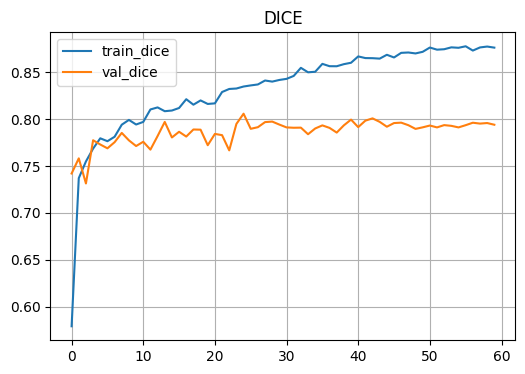

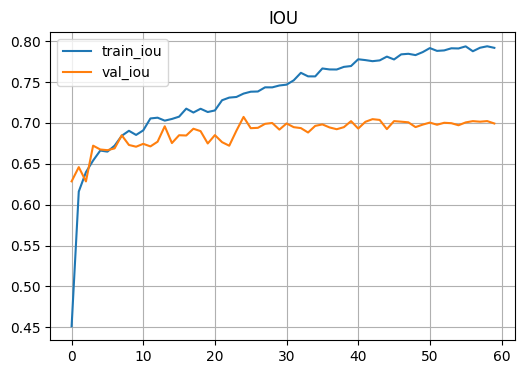

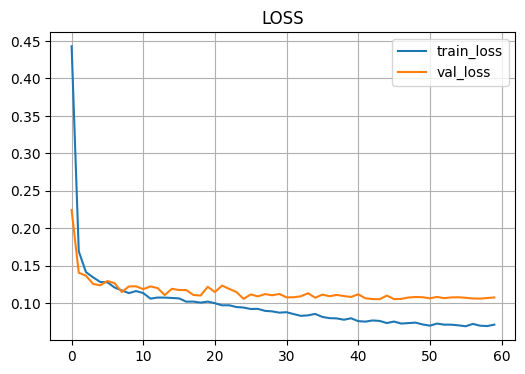

✅ Summary: /content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp/summary_unetpp_wbc_20251029_0103


In [ ]:
# Charts
import pandas as pd, matplotlib.pyplot as plt, numpy as np, cv2, glob
df = pd.read_csv(RUN_DIR/"training_log.csv")
for cols, name in [(["train_dice","val_dice"],"dice"), (["train_iou","val_iou"],"iou"), (["train_loss","val_loss"],"loss")]:
    plt.figure(figsize=(6,4))
    for c in cols: plt.plot(df[c], label=c)
    plt.title(name.upper()); plt.grid(True); plt.legend(); plt.savefig(RUN_DIR/f"{name}_vs_epoch.png", dpi=160, bbox_inches="tight"); plt.show()

# Predictions (overlay)
model.load_state_dict(torch.load(BEST, map_location=DEVICE)); model.eval()
PRED_DIR = RUN_DIR / "predictions_test"; PRED_DIR.mkdir(exist_ok=True)
samples = sorted([p for p in IMG_TEST.iterdir() if p.suffix.lower() in (".jpg",".jpeg",".png",".tif",".tiff")])[:16]

def infer_mask(img_rgb, size=512):
    im = cv2.resize(img_rgb,(size,size)); x=torch.from_numpy(im.transpose(2,0,1)).float().unsqueeze(0)/255.0; x=x.to(DEVICE)
    with torch.no_grad(): z=model(x); pr=(torch.sigmoid(z)[0,0].cpu().numpy()>0.5).astype(np.uint8)*255
    return im, pr

for p in samples:
    img = cv2.imread(str(p))[:,:,::-1]
    im, m = infer_mask(img, IMGSZ)
    ov = im.copy(); ov[m>0]=(255,0,0)
    cv2.imwrite(str(PRED_DIR/f"{p.stem}_overlay.jpg"), ov[:,:,::-1])

# Summary
import shutil
SUMMARY = RESULTS_DIR / f"summary_{RUN_NAME}"; SUMMARY.mkdir(exist_ok=True)
for f in ["training_log.csv","dice_vs_epoch.png","iou_vs_epoch.png","loss_vs_epoch.png"]:
    fp = RUN_DIR/f;
    if fp.exists(): shutil.copy(fp, SUMMARY/fp.name)
shutil.copy(BEST, SUMMARY/"unetpp_best.pth")
for p in list(PRED_DIR.glob("*.jpg"))[:8]:
    shutil.copy(p, SUMMARY/p.name)
print("✅ Summary:", SUMMARY)

In [ ]:
#for calculating accuracy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/urine_uti/ml-services/kasundi/results/wbc_unetpp/unetpp_wbc_20251029_0103/training_log.csv"

===== PERFORMANCE SUMMARY =====
Best Validation Dice: 0.8058
Best Validation IoU : 0.7073

Mean Validation Dice: 0.7862
Mean Validation IoU : 0.6880

Final Validation Dice: 0.7940
Final Validation IoU : 0.6992


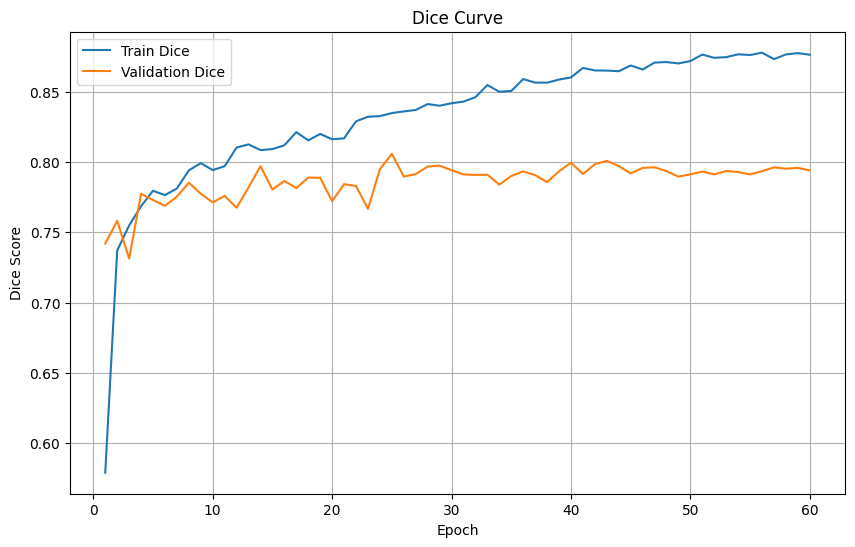

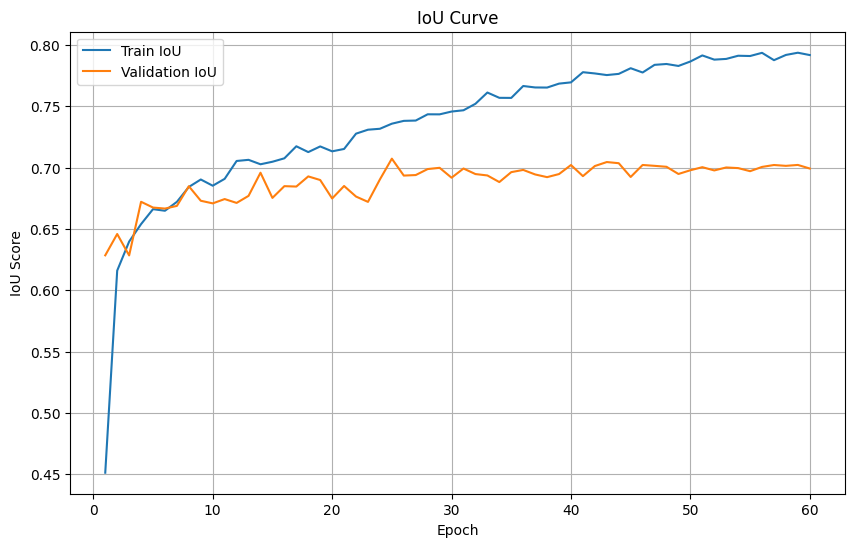

In [ ]:
# ----------------------------
# 1. Import Libraries
# ----------------------------
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# Load CSV
df = pd.read_csv(file_path)

# ----------------------------
# 3. Compute Performance Stats
# ----------------------------
best_val_dice = df['val_dice'].max()
best_val_iou = df['val_iou'].max()

mean_val_dice = df['val_dice'].mean()
mean_val_iou = df['val_iou'].mean()

final_val_dice = df['val_dice'].iloc[-1]
final_val_iou = df['val_iou'].iloc[-1]

print("===== PERFORMANCE SUMMARY =====")
print(f"Best Validation Dice: {best_val_dice:.4f}")
print(f"Best Validation IoU : {best_val_iou:.4f}")
print()
print(f"Mean Validation Dice: {mean_val_dice:.4f}")
print(f"Mean Validation IoU : {mean_val_iou:.4f}")
print()
print(f"Final Validation Dice: {final_val_dice:.4f}")
print(f"Final Validation IoU : {final_val_iou:.4f}")

# ----------------------------
# 4. Plot Dice Curves
# ----------------------------
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['train_dice'], label='Train Dice')
plt.plot(df['epoch'], df['val_dice'], label='Validation Dice')
plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.title("Dice Curve")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# 5. Plot IoU Curves
# ----------------------------
plt.figure(figsize=(10,6))
plt.plot(df['epoch'], df['train_iou'], label='Train IoU')
plt.plot(df['epoch'], df['val_iou'], label='Validation IoU')
plt.xlabel("Epoch")
plt.ylabel("IoU Score")
plt.title("IoU Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# What is the “model accuracy” in segmentation?
# For image segmentation, accuracy is NOT the correct metric because:
# Most pixels are background
# Accuracy becomes misleading (e.g., 95% accuracy even if segmentation fails)
# Therefore, segmentation models like U-Net, U-Net++, DeepLab, etc. use:
# ✔ Dice Coefficient (F1-score for segmentation)
# ✔ Intersection over Union (IoU)

# These are the meaningful accuracy metrics.
# 🟦 So what should you report as “model accuracy”?
# 📌 Primary Accuracy Metric → Dice Score
# Dice reflects overlap between prediction and ground truth.

# Use:
# Best Dice: 0.8058
# Final Dice: 0.7940

# Your model's real “accuracy” is ~0.80 Dice (80%).
# 🟩 Secondary Metric → IoU
# IoU is more strict than Dice.
# Use:
# Best IoU: 0.7073
# Final IoU: 0.6992
# So IoU accuracy is ~0.70 (70%).

# ⭐ Recommended text for your report
# You can paste this directly into your research report:
# Model Performance Summary
# To evaluate the segmentation performance of the U-Net++ model, we used Dice coefficient and Intersection-over-Union (IoU), which are the standard accuracy metrics for medical image segmentation.
# Best Validation Dice: 0.8058
# Best Validation IoU: 0.7073
# Mean Validation Dice: 0.7862
# Mean Validation IoU: 0.6880
# Final Validation Dice: 0.7940
# Final Validation IoU: 0.6992

# These results indicate that the model achieves approximately 80% segmentation accuracy (Dice) and 70% region overlap accuracy (IoU) on the validation set, demonstrating strong and stable performance with no significant overfitting.

In [ ]:
#TOP 6 METHODS TO IMPROVE U-Net++ ACCURACY
# I’ll give the code for ALL of them:
# 1. Use better data augmentation → Huge accuracy boost
# 2. Use a stronger encoder backbone (EfficientNet, ResNet50, DenseNet)
# 3. Use Dice + BCE or Focal loss
# 4. Use learning rate scheduler
# 5. Increase input image size
# 6. Use model checkpointing & early stopping